# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

## Import initial libraries

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os

import warnings
warnings.filterwarnings('ignore')

## Working with Shape File

### Loading Census Tract Shape File¶

In [2]:
from geopandas import GeoDataFrame
ct_shape = GeoDataFrame.from_file("Data/CT_Shape/ct_shape.shp")
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [3]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

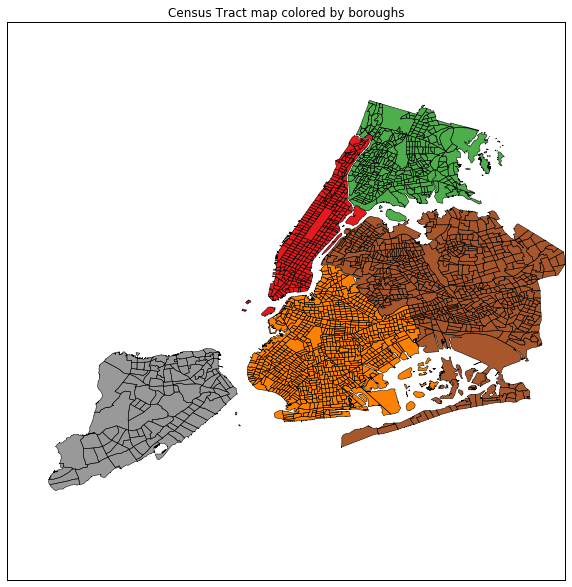

In [4]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [5]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [6]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

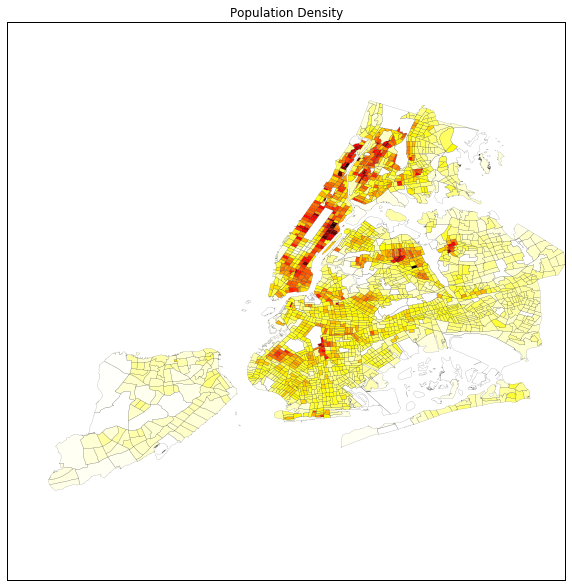

In [9]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [10]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_bike_month = df_bike_monthly.groupby(df_bike_monthly.index.month).sum()

In [12]:
df_bike_month.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
1,2820,3006,10897,4346,6216,4502,1575,5396,2448,2235,...,0,0,0,0,0,0,0,0,0,0
2,2412,2911,9963,3677,5674,4297,1723,4882,1854,2059,...,0,0,0,0,0,0,0,0,0,0
3,3707,4740,16397,5371,9430,7216,3099,7886,3610,3543,...,0,0,0,0,0,0,0,0,0,0
4,5194,8405,21667,8217,14557,9925,4619,11998,5618,5083,...,310,0,0,0,0,0,0,0,0,0
5,6488,13275,28581,11073,19018,13067,6213,14416,7692,6787,...,901,62,20,2859,394,0,0,0,0,0


## Map CitiBike Data to CT level

### Load CitiBike station location data

In [13]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [14]:
import shapely
# combine lat and lon to one column
station_id['lonlat'] = list(zip(station_id.lon,station_id.lat))
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [15]:
a = []
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
station_id['BoroCT2010'] = a

In [16]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [17]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['Summer'] = df_bike_month[5:8].sum()
station_id['Winter'] = df_bike_month.ix[[1,2,12],:].sum()

In [18]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,Summer,Winter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890,21889


### Add the monthly average rides to the CT shapefile 

In [19]:
temp=station_id[['Summer', "Winter"]]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

### Removing the CTs that are out of zoom boundries

In [20]:
ct_shape_MonthlyAve_Zoom = (ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [22]:
print ("Total number of CTs:", len(ct_shape))
print ("Number of zoomed summer CTs:", len(temp.Summer))
print ("Number of zoomed winter CTs:", len(temp.Summer))

('Total number of CTs:', 2166)
('Number of zoomed summer CTs:', 543)
('Number of zoomed winter CTs:', 543)


### Map the monthly rides 

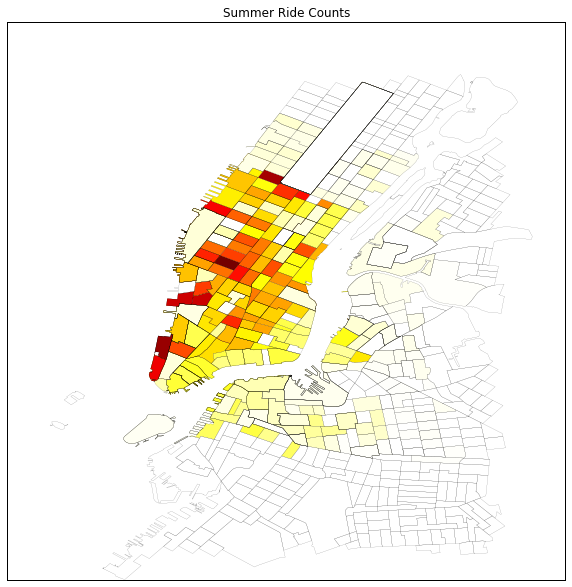

In [23]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='Summer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

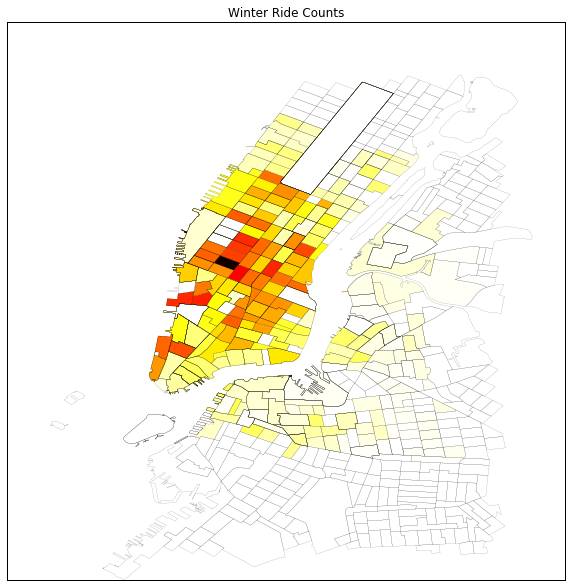

In [24]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='Winter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [25]:
ct_shape_MonthlyAve_Zoom.to_file('Data/ct_shape_Summer_Zoom.shp')

## Exploratory Geospatial Analysis

In [27]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [28]:
qW_CT=ps.queen_from_shapefile('Data/ct_shape_Summer_Zoom.shp')

('Island id: ', [0])


#### Neighbors of index10

In [29]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [30]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [31]:
Wmatrix, ids = qW_CT.full()

In [32]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [33]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [34]:
MonthlyRide_summer = ct_shape_MonthlyAve_Zoom.Summer
MonthlyRide_winter = ct_shape_MonthlyAve_Zoom.Winter
MonthlyRideLag_summer = ps.lag_spatial(qW_CT, MonthlyRide_summer)
MonthlyRideLag_winter = ps.lag_spatial(qW_CT, MonthlyRide_winter)

#### Create Quantiles for maping

In [35]:
MonthlyRideLagQ10_summer = ps.Quantiles(MonthlyRideLag_summer, k=10)
MonthlyRideLagQ10_winter = ps.Quantiles(MonthlyRideLag_winter, k=10)

#### Map the monthly rides lag

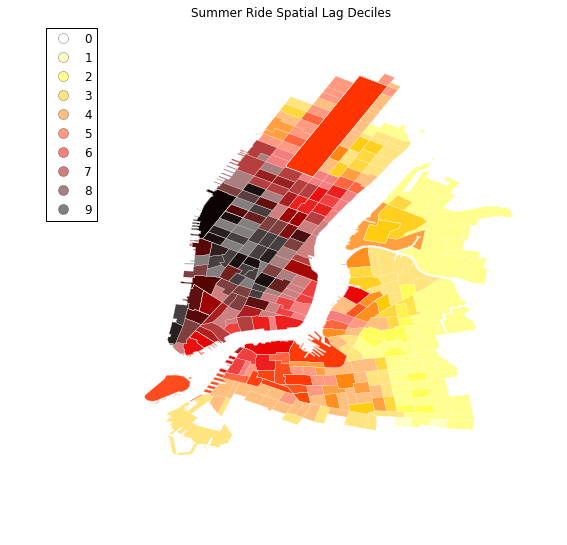

In [36]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10_summer.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")

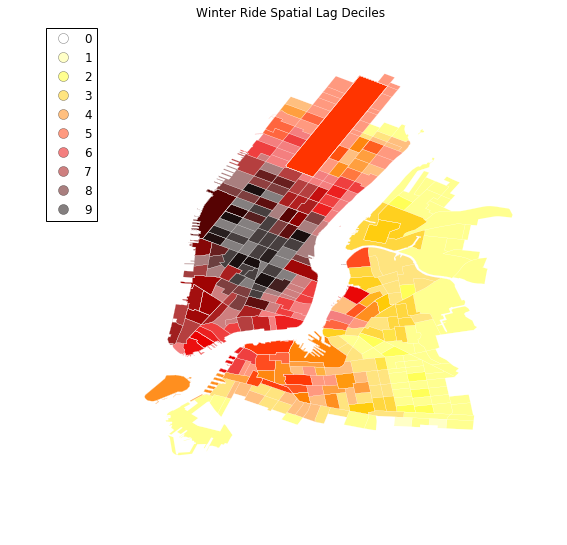

In [37]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10_winter.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation

In [38]:
b_s, a_s = np.polyfit(MonthlyRide_summer, MonthlyRideLag_summer, 1)
b_w, a_w = np.polyfit(MonthlyRide_winter, MonthlyRideLag_winter, 1)

### Moran Scatterplot

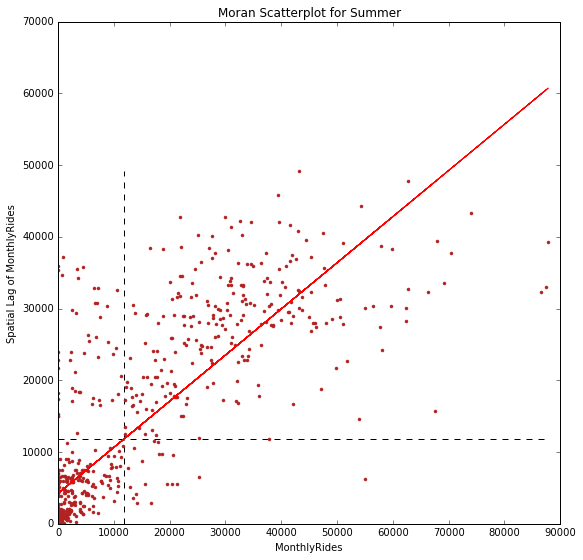

In [39]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_summer, MonthlyRideLag_summer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a_s + b_s*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot for Summer')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

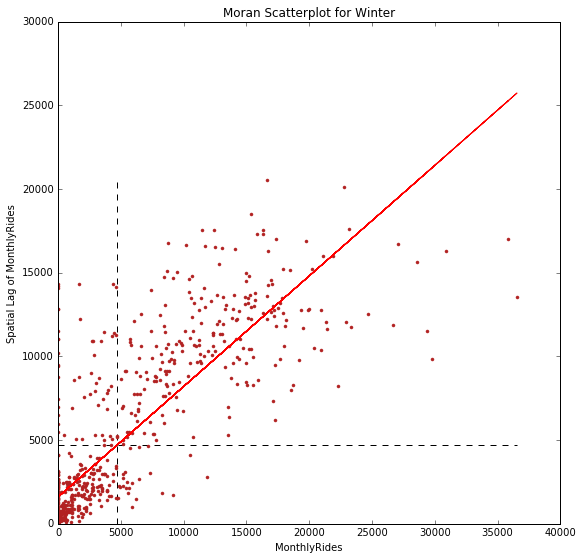

In [40]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_winter, MonthlyRideLag_winter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a_w + b_w*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot for Winter')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Moran's I

In [41]:
I_MonthlyRide_summer = ps.Moran(MonthlyRide_summer, qW_CT)
I_MonthlyRide_winter = ps.Moran(MonthlyRide_winter, qW_CT)

Summer Moran's I 

In [42]:
I_MonthlyRide_summer.I, I_MonthlyRide_summer.p_sim

(0.64353398667011008, 0.001)

Winter Moran's I

In [43]:
I_MonthlyRide_winter.I, I_MonthlyRide_winter.p_sim

(0.66039156431885593, 0.001)

## Local  Spatial Autocorrelation

In [44]:
LMo_MonthlyRide_summer = ps.Moran_Local(np.array(MonthlyRide_summer), qW_CT, permutations=999)
LMo_MonthlyRide_winter = ps.Moran_Local(np.array(MonthlyRide_winter), qW_CT, permutations=999)

Summer autocorrelation

In [45]:
LMo_MonthlyRide_summer.Is[0:5], LMo_MonthlyRide_summer.p_sim[0:5]

(array([-0.        , -0.2391325 ,  0.01474643,  0.00173718,  0.02473794]),
 array([ 0.001,  0.185,  0.344,  0.337,  0.342]))

Winter autocorrelation

In [46]:
LMo_MonthlyRide_winter.Is[0:5], LMo_MonthlyRide_winter.p_sim[0:5]

(array([ -0.00000000e+00,  -3.14119985e-01,  -1.93084894e-04,
         -4.03594530e-03,  -7.97531288e-02]),
 array([ 0.001,  0.128,  0.481,  0.481,  0.409]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [47]:
sigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim <= .001]
W_sigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim <= .001]
insigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim > .001]
W_insigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim > .001]

In [48]:
sigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim <= .001]
W_sigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim <= .001]
insigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim > .001]
W_insigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim > .001]

### Plot Signficant LISA

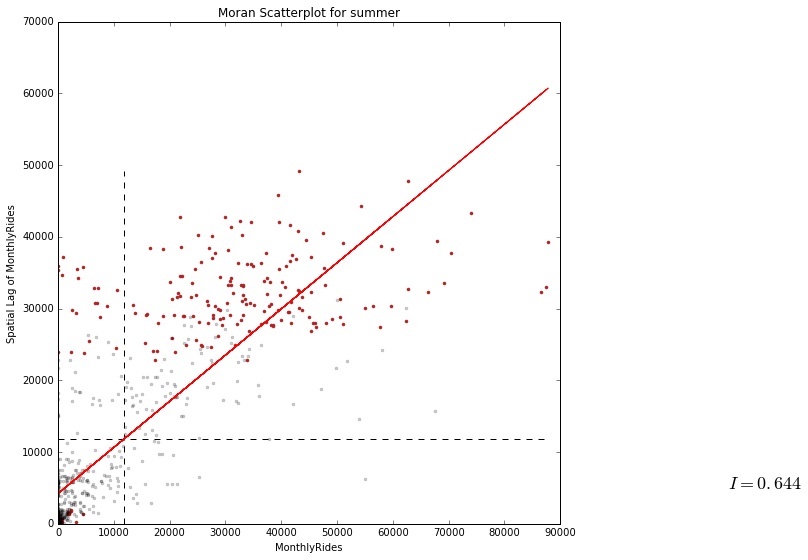

In [49]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_summer.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a_s + b_s*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot for summer')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


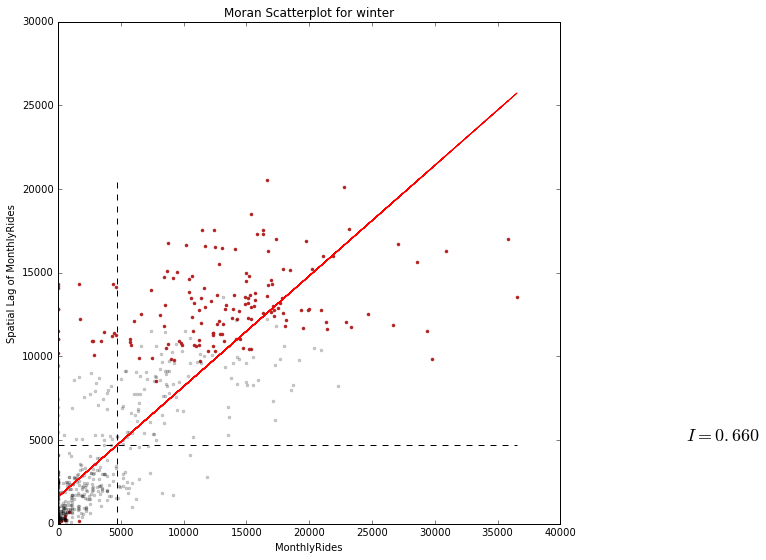

In [50]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_winter, W_sigs_winter, '.', color='firebrick')
plt.plot(insigs_winter, W_insigs_winter, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_winter.I, x=50000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a_w + b_w*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot for winter')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

####  In summer, the autocorrelation is smaller than in winter, meaning that winter ridership tends to have a stronger correaltion. 

### Hot and Cold spots 

In [51]:
ct_shape_MonthlyAve_Zoom.columns

Index([u'BoroCT2010',   u'BoroCode',   u'BoroName', u'CDEligibil',
           u'CT2010',    u'CTLabel',    u'NTACode',    u'NTAName',
             u'PUMA', u'Shape_Area', u'Shape_Leng',   u'geometry',
           u'Summer',     u'Winter', u'station_id'],
      dtype='object')

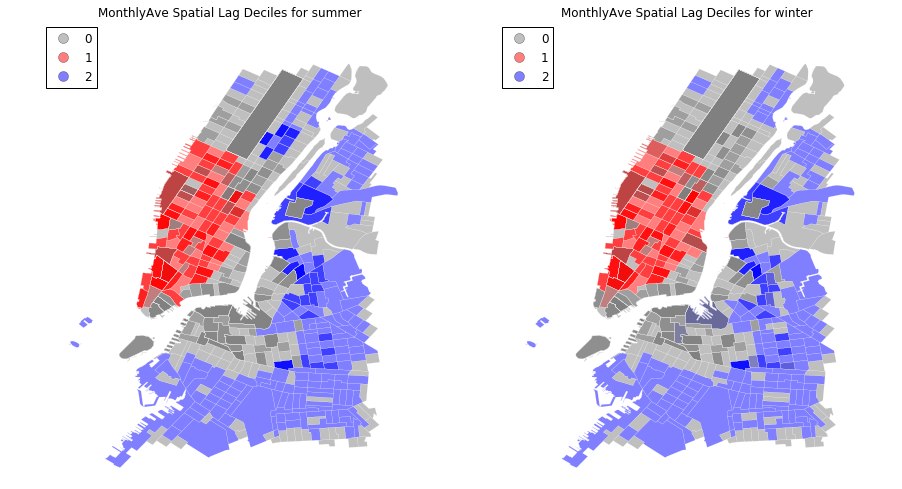

In [52]:
from matplotlib import colors
sig_summer = LMo_MonthlyRide_summer.p_sim < 0.01
hotspots_summer = LMo_MonthlyRide_summer.q==1 * sig_summer
coldspots_summer = LMo_MonthlyRide_summer.q==3 * sig_summer
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_summer = hotspots_summer*1 + coldspots_summer*2
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold_summer).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax1.set_title("MonthlyAve Spatial Lag Deciles for summer")

sig_winter = LMo_MonthlyRide_winter.p_sim < 0.01
hotspots_winter = LMo_MonthlyRide_winter.q==1 * sig_winter
coldspots_winter = LMo_MonthlyRide_winter.q==3 * sig_winter
hotcold_winter = hotspots_winter*1 + coldspots_winter*2

ax2 = fig.add_subplot(122)
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold_winter).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
ax2.set_title("MonthlyAve Spatial Lag Deciles for winter")